# Algoritmos de detección de comunidades


A continuación, se detallan algunos algoritmos de detección de comunidades. Es necesario prestar atención a las características de las funciones que implementan los algoritmos, ya que el output de las mismas suele variar.

# Instalamos e importamos librerías

In [1]:
!pip install python-louvain # Instalo un paquete que tiene Louvain y modularidad
!pip install python-igraph # Voy a usar igraph para infomap (tiene un montón de algoritmos de comunidades incluido)
!apt-get install libcairo2-dev libjpeg-dev libgif-dev # Para graficar Igraph (acá dendrogramas)
!pip install pycairo # Igraph usa Cairo para graficar

     |████████████████████████████████| 3.2MB 8.4MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libgif-dev libpixman-1-dev
  libxcb-shm0-dev
0 upgraded, 5 newly installed, 0 to remove and 43 not upgraded.
Need to get 951 kB of archives.
After this operation, 4,084 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubu

In [0]:
import networkx as nx # Para redes en general
import community as community_louvain # Importo el paquete que instalé en la línea de arriba
import igraph as ig # Importo igraph
import matplotlib.pylab as plt # Para graficar networkx y demases
import matplotlib.cm as cm # para mapas de colores
import numpy as np
from sklearn.metrics import normalized_mutual_info_score as mis # Función para calcular información mutua
import cairo # Importo Cairo
# Esto es para que funcione Cairo
from google.colab import files
from IPython.display import SVG, display, Image
def show_svg(file):
    display(SVG(filename=file))

# Cargamos las redes directamente de la página de la materia

In [0]:
# Primero, uso de los códigos subidos al cuaderno colaborativo para conseguir los datos del ejercicio
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
url = "http://materias.df.uba.ar/scytda2020c1/files/2020/04/TC04_ComunidadesData.zip"
with urlopen(url) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
       archivos = zfile.namelist()
       for archivo in archivos:
           if archivo.endswith('.txt') or archivo.endswith('.gml') or archivo.endswith('.csv'):
               zfile.extract(archivo, '/content')


# Ejercicio 1

### Inciso (a)

la partición en comunidades de esta red utilizando la metodología Louvain, infomap,
fast_greedy y edge_betweenness. Visualice los resultados gráficamente.

In [0]:
#cargamos la red de delfines
Red_delfines = nx.read_gml('/content/dolphins.gml')
posiciones = nx.kamada_kawai_layout(Red_delfines)

#definimos la red en Igraph desde la red en Networkx
Red_delfines_igraph = ig.Graph.TupleList(Red_delfines.edges(), directed=False)



In [24]:
%store -r masculinos
%store -r femeninos
%store -r sin_genero

no stored variable masculinos
no stored variable femeninos
no stored variable sin_genero
no stored variable gender_dict


In [0]:
#hago un diccionario con los datos del txt
def gend_dict(filename):      
   g_dict = {}
   with open(filename) as f:
      for line in f:
         data = line.strip().split()
         key = data[0]
         data = data[1]
         g_dict[key] = data

   return g_dict

gender_dict = gend_dict('/content/dolphinsGender.txt')

In [0]:
#guardamos el genero como atributo de shape de cada nodo

shape_dict = {}
for nodo in Red_delfines.nodes(): 
    if gender_dict[nodo] == 'm':
        shape_dict[nodo] = 's' 
    if gender_dict[nodo] == 'f':
        shape_dict[nodo] = '*' 
    if gender_dict[nodo] == 'NA':
        shape_dict[nodo] = '^'
nx.set_node_attributes(Red_delfines, shape_dict, 'shape')

shapes = set([nodo[1]['shape'] for nodo in Red_delfines.nodes(data = True)])

In [0]:
# función que toma la Red de igraph y la partición calculada con Igraph, y la devuelve como diccionario
def convertir_particion_igraph_a_diccionario(Red_igraph,particion_igraph):
  particion_dict = {}
  for cluster in range(len(particion_igraph)):
    for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
      particion_dict.update({nodo:cluster})
  return particion_dict

def convertir_dict_a_lista(dict):
  categoria = set(dict.values())
  particiones = []
  for n in categoria:
    cluster = [k for k in dict.keys() if dict[k] == n]
    particiones.append(cluster)
  return particiones_louvline

#devuelve una lista de n colores hex
import random
def colores_hex(n):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(n)]
    return color


In [0]:
#calculamos las paticiones con los distintos métodos
particiones = {}

#particiones con Edge Betweenness
dendograma_edge_betweenness = Red_delfines_igraph.community_edge_betweenness(directed=False, weights=None)
particiones_edge_betweenness = dendograma_edge_betweenness.as_clustering()
dict_particiones_edge_betweenness = convertir_particion_igraph_a_diccionario(Red_delfines_igraph,particiones_edge_betweenness)
particiones['Edge Betweenness'] = dict_particiones_edge_betweenness

#particiones con Fast Greedy
dendograma_fast_greedy = Red_delfines_igraph.community_fastgreedy(weights=None)
particiones_fast_greedy = dendograma_fast_greedy.as_clustering()
dict_particiones_fast_greedy = convertir_particion_igraph_a_diccionario(Red_delfines_igraph,particiones_fast_greedy)
particiones['Fast Greedy'] = dict_particiones_fast_greedy

#particiones con Louvline
dict_particiones_louvline = community_louvain.best_partition(Red_delfines)
particiones['Louvline'] = dict_particiones_louvline
#convertir_dict_a_lista(dict_particiones_louvline)

#particiones con infomap
particiones_infomap = Red_delfines_igraph.community_infomap()
dict_particiones_infomap = convertir_particion_igraph_a_diccionario(Red_delfines_igraph,particiones_infomap)
particiones['Infomap'] = dict_particiones_infomap

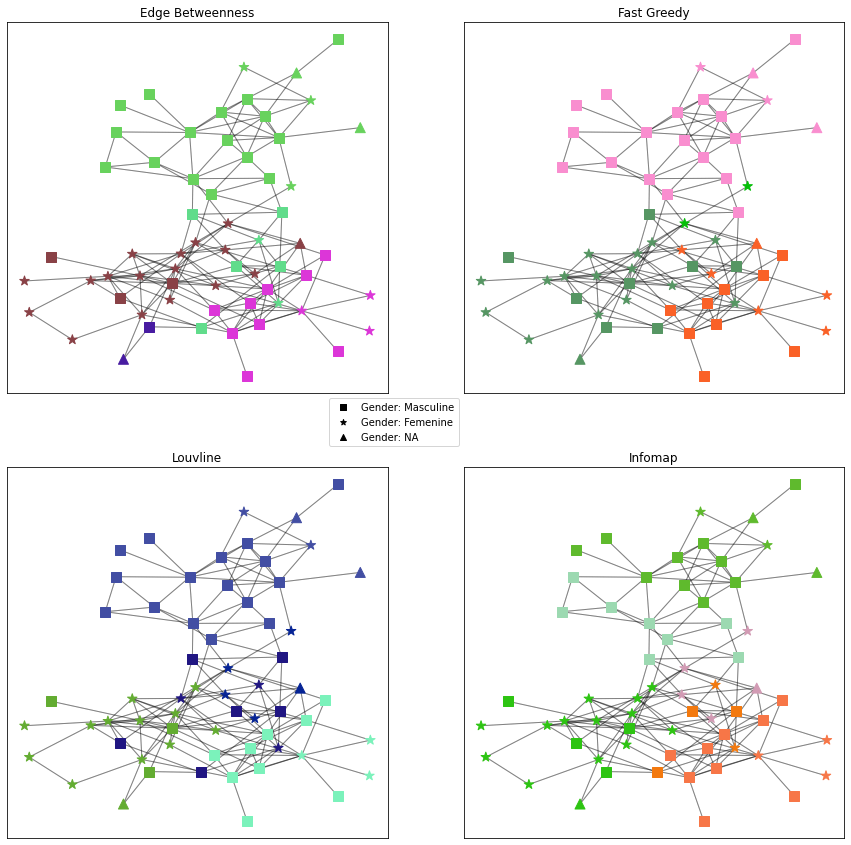

In [37]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for i,metodo in enumerate(particiones):
    particion = particiones[metodo]
    colores = colores_hex(max(particion.values())+1) #funcion que devuelve n colores

    node_color_dict = {}
    for node in Red_delfines.nodes():
        node_color_dict[node] = colores[particion[node]]
            
    for aShape in shapes: 
        
        node_list = [sNode for sNode, attr in Red_delfines.nodes(data = True) if attr['shape'] == aShape]
        node_color = [node_color_dict[sNode] for sNode in node_list]
        #nx.draw(Red_delfines, node_size= 100, ax = axs[i], node_color = node_color,pos=posiciones, node_shape = aShape,  nodelist = node_list)
        nx.draw_networkx_nodes(Red_delfines,node_size= 100, ax = axs[i], node_color=node_color,pos=posiciones,node_shape = aShape,  nodelist = node_list)
        nx.draw_networkx_edges(Red_delfines, ax = axs[i], width=1.0, alpha=0.2,pos=posiciones)
    axs[i].set_title(metodo)
    
    label = {'s': 'Masculine', '*':'Femenine', '^':"NA"}
for aShape in shapes:
    plt.scatter([],[], c = 'black', marker = aShape, label='Gender: {}'.format(label[aShape]))

plt.legend(bbox_to_anchor=(0, 1.2))
plt.show()

### Inciso (b)
La modularidad es un escalar que se define como la diferencia entre la cantidad de enlaces que unen nodos de la misma clase para una red dada, y la cantidad esperada de dichos enlaces en una red aleatoria con la misma distribución de grado. De esta manera, valores positivos de la modularidad indican que existe clustering entre los nodos pertenecientes a una misma clase en la red, mientras que valores negativos indican la situación contraria.

Es importante notar que los algoritmos utilizados en el inciso anterior se basan en elegir una clasifcación que maximice la modularidad, partiendo de una red que no posee clasificación alguna. Es por ello que, por construcción, todas las particiones obtenidas a partir de dicho proceso tendrán modularidad positiva.

En la siguiente tabla se muestran los valores obtenidos para la modularidad Q

In [8]:
Coeficientes = {}
for i,metodo in enumerate(particiones):
  particion = particiones[metodo]
  mod = community_louvain.modularity(particion,Red_delfines)
  Coeficientes[metodo] = {}
  Coeficientes[metodo]['Modularidad'] = mod
print(Coeficientes)

{'Edge Betweenness': {'Modularidad': 0.5193821446936435}, 'Fast Greedy': {'Modularidad': 0.49232625291721055}, 'Louvline': {'Modularidad': 0.5285194414777896}, 'Infomap': {'Modularidad': 0.5189470353229697}}


Otra cantidad que permite medir el grado de agrupamiento en comunidades de una red
es el coeficiente de silouhette, que cuantifica la diferencia entre la distancia mínima de un nodo dado a un
nodo de una comunidad distinta a la suya y la distancia media de dicho nodo al resto de los
nodos de su comunidad.  

In [0]:
def Silhouette(Red,particion): # La función nos pide la Red y la partición como diccionario
  S=[]
  limites=[0]
  # Recorro los clusters sin repetir
  for cluster in set(particion.values()): 
    #Filtro los nodos que pertenecen a este cluster
    nodos_en_cluster = [nodo for (nodo, value) in particion.items() if value == cluster] 
    S_cluster=[]
    # Recorro los nodos del cluster
    for nodo in nodos_en_cluster:
      distancias_dentro=[]
      distancias_fuera=[]
      # Recorro los nodos del mismo cluster
      for nodo_en_cluster in nodos_en_cluster:
        if nodo != nodo_en_cluster:
          # Calculo y guardo la distancia, si no es consigo mismo
          distancias_dentro.append(nx.shortest_path_length(Red, source=nodo, target=nodo_en_cluster, weight=None))
      # Recorro los nodos de los otros clusters
      for nodo_fuera in Red.nodes():
        if particion[nodo_fuera] != cluster:
          # Calculo y guardo la distancia
          distancias_fuera.append(nx.shortest_path_length(Red, source=nodo, target=nodo_fuera, weight=None)) 
      # Calculo la distancia media para los del mismo cluster
      if distancias_dentro == []:
        distancia_media_dentro = 0
      else:
        distancia_media_dentro=np.mean(distancias_dentro)
      # Calculo la distancia mínima para los nodos fuera del cluster
      if distancias_fuera == []:
        distancia_min_fuera = 0
      else:
        distancia_min_fuera=np.min(distancias_fuera)
      # Calculo y guardo la Silhouette del nodo
      S_cluster.append((distancia_min_fuera-distancia_media_dentro)/np.max([distancia_min_fuera,distancia_media_dentro]))
    # Ordeno las Silhouette del mismo cluster por valor, para graficar lindo
    S_cluster=sorted(S_cluster)
    # Me guardo en qué nodo termina cada cluster, para graficar clusters por colores
    limites.append(len(S_cluster)+limites[-1])
    # Agrego las Silhouette de este cluster a la lista de todas
    S = S + S_cluster
  # Calculo la Silhouette media
  S_media = np.mean(S)

  return S,S_media,limites


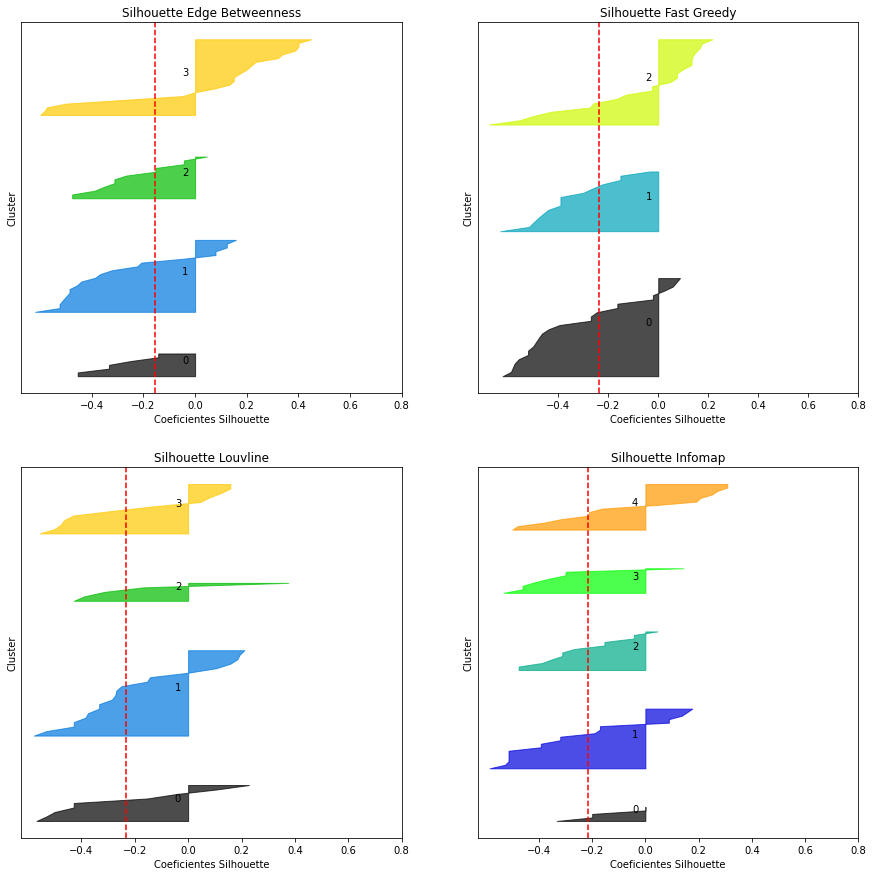

In [17]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for n,metodo in enumerate(particiones):
  particion = particiones[metodo]
  sample_silhouette_values,silhouette_avg,limites = Silhouette(Red_delfines,particion)
  Coeficientes[metodo]['Silhouette'] = silhouette_avg
  y_lower = 10
  n_clusters = max(particion.values())
  for i in range(n_clusters):
      # agrego los Silhouette values de las muestras del cluster i y los ordeno
      values = list(particion.values())
      ith_cluster_silhouette_values = [s_val for j, s_val in enumerate(sample_silhouette_values) if values[j] == i] 
      ith_cluster_silhouette_values.sort()

      size_cluster_i = len(ith_cluster_silhouette_values) #.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      axs[n].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

      # pongo el label del cluster en la mitad del cluster 
      axs[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # reseteo el lower segun el nuevo upper
      y_lower = y_upper + 10  # 10 for the 0 samples

  axs[n].set_title(f"Silhouette {metodo}")
  axs[n].set_xlabel("Coeficientes Silhouette")
  axs[n].set_ylabel("Cluster")
  axs[n].axvline(x=silhouette_avg, color="red", linestyle="--") #linea que marca el silhouette score medio

  axs[n].set_yticks([]) 
  axs[n].set_xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8])


Resulta importante contar con una herramienta que
permita discernir si estos métodos de clasificaión establecida denotan realmente la existencia de comunidades
en la red o si, por el contrario, el algoritmo forzó una clasificación "espuria" que no se condice
con la naturaleza de las interacciones sociales representadas por la red original. Una manera de
decidir esto es aplicar los mismos algoritmos a redes con la misma distribución de grado pero
recableadas al azar: si la clasifcación obtenida para la red original fue espuria, esperamos que,
partiendo de las redes recableadas al azar, el algoritmo continue convergiendo, en promedio, a
un valor similar de la modularidad (es decir, cualquier red con la misma distribución de grado se
puede clasificar de manera tal que se alcance dicho valor de la modularidad, independientemente
de la naturaleza de la red); si esto no sucede, es razonable aventurar que la clasificación obtenida
para la red original contiene información real sobre las interacciones entre los delfines y no fue
una simple consecuencia de la distribución de grados de la misma.

Para encontrar los nuevos valores de Modularidad se utilizan recableados con las particiones originales. De esta forma se mantiene firme la noción original de dichas particiones.
En el caso de Silhouette esto no es posible por la definición de susodicho coeficiente. Por esta misma razón se calculan nuevas particiones para cada recableo. Los recableos se realizan manteniendo el grado y al grafo conectado, intentando que replique la red original lo más fielmente posible y así darle al método de clasificación mayor confianza.

In [0]:
import random 

# devuelve particiones con Edge Betweenness
def edge_betweenness(Red_recableada): 
  Red_igraph = ig.Graph.TupleList(Red_recableada.edges(), directed=False) #la paso a igraph
  dendograma_edge_betweenness = Red_igraph.community_edge_betweenness(directed=False, weights=None)
  particiones_edge_betweenness = dendograma_edge_betweenness.as_clustering()
  dict_particiones_edge_betweenness = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_edge_betweenness)
  return dict_particiones_edge_betweenness

#devuelve particiones con Fast Greedy
def fast_greedy(Red_recableada):
  Red_igraph = ig.Graph.TupleList(Red_recableada.edges(), directed=False) #la paso a igraph
  dendograma_fast_greedy = Red_igraph.community_fastgreedy(weights=None)
  particiones_fast_greedy = dendograma_fast_greedy.as_clustering()
  dict_particiones_fast_greedy = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_fast_greedy)
  return dict_particiones_fast_greedy

#particiones con Louvline
def louvile(Red_recableada):
  dict_particiones_louvline = community_louvain.best_partition(Red_recableada)
  return dict_particiones_louvline


#particiones con infomap
def infomap(Red_recableada):
  Red_igraph = ig.Graph.TupleList(Red_recableada.edges(), directed=False) #la paso a igraph
  particiones_infomap = Red_igraph.community_infomap()
  dict_particiones_infomap = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_infomap)
  return dict_particiones_infomap

array_funciones = [edge_betweenness,fast_greedy,louvile,infomap]

#el recableo me devuelve un grafo conectado (1 sola componente)
def recableado(red): 
  Red = red.copy()
  #hago este recableo falopa porque el double_edge a veces me tire un runtime error
  enlaces_originales = Red.edges()
  e1 = [x[1] for x in enlaces_originales]
  e2 = [x[0] for x in enlaces_originales]
  random.shuffle(e2) #los reacomodo de una manera arbitraria
  enlaces_nuevos = list(zip(e1,e2))
        
  #creo una red nueva 
  Red_recableada=nx.Graph()
  lista_nodos = Red.nodes()
  lista_enlaces = enlaces_nuevos
  Red_recableada.add_nodes_from(lista_nodos)
  Red_recableada.add_edges_from(lista_enlaces)
  Red_recableada = nx.double_edge_swap(Red, nswap=50, max_tries=100)
  subgrafos = list((Red_recableada.subgraph(c) for c in nx.connected_components(Red_recableada)))
  while len(subgrafos) != 1: #si no es un grafo conectado, que recablee
    Red_recableada = nx.double_edge_swap(Red, nswap=50, max_tries=100)
    subgrafos = list((Red_recableada.subgraph(c) for c in nx.connected_components(Red_recableada)))


  return Red_recableada
  

#Esta funcion me va a devolver dos listas con los valores de silhouette medio y modularidad de n recableados aleatorios
def silhouette_modularidad_random(Red,num_recableos,array_funciones,n_metodo,particion_original):
  nodos = Red.nodes()
  cant_nodos = len(nodos)
  lista_media_silhouette = []
  lista_valores_modularidad = []
    
  for i in range(num_recableos): #la recableo n veces
    Red = Red.copy()
    Red_recableada = recableado(Red)
    #print(type(Red_recableada))
    particion_red_recableada = array_funciones[n_metodo](Red_recableada)
    #print(particion_red_recableada)
    silhouette_values,silhouette_media,limites = Silhouette(Red_recableada,particion_red_recableada) #valor medio de silhouette
    #print(silhouette_media)
    modularidad = community_louvain.modularity(particion_original,Red_recableada) # valor de modularidad

    lista_media_silhouette.append(silhouette_media)
    lista_valores_modularidad.append(modularidad)
   
  return lista_media_silhouette,lista_valores_modularidad

En el siguiente código visualizamos los histogramas con la distribucion de valores de Modularidad y Silhouette realizado con 100 recableados para cada metodo. Lo comparamos con el valor real de la red.

In [0]:
print(Coeficientes)

{'Edge Betweenness': {'Modularidad': 0.5193821446936435, 'Silhouette': -0.15398520454196274}, 'Fast Greedy': {'Modularidad': 0.49232625291721055, 'Silhouette': -0.23555432023573228}, 'Louvline': {'Modularidad': 0.5176614849096159, 'Silhouette': -0.19744649818082216}, 'Infomap': {'Modularidad': 0.5189470353229697, 'Silhouette': -0.21743446013591025}}


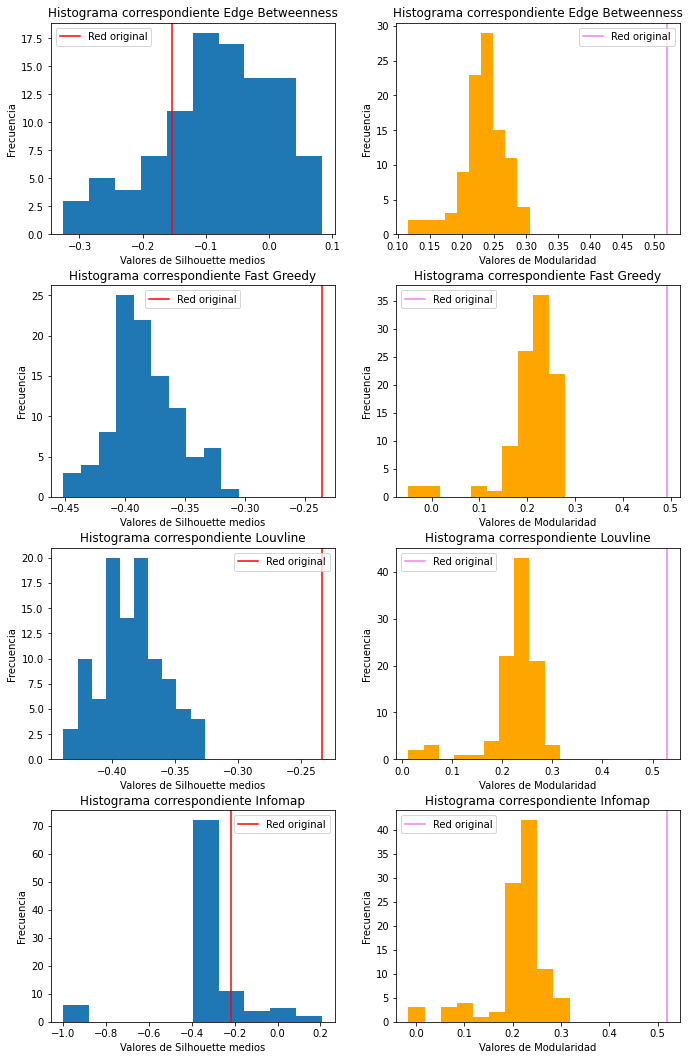

In [12]:
f, axs = plt.subplots(4, 2, figsize=(10,15))
f. tight_layout(pad=3.0)
for n,metodo in enumerate(particiones):
  particion = particiones[metodo]
  lista_media_silhouette,lista_valores_modularidad= silhouette_modularidad_random(Red_delfines,100,array_funciones,n,particion)

  #grafico Silhouette
  axs[n][0].hist(lista_media_silhouette)
  axs[n][0].set_xlabel('Valores de Silhouette medios')
  axs[n][0].set_ylabel('Frecuencia')
  axs[n][0].set_title(f'Histograma correspondiente {metodo}')
  axs[n][0].axvline(Coeficientes[metodo]['Silhouette'], label = 'Red original',c='red')
  axs[n][0].legend()

  #grafico Modularidad
  axs[n][1].hist(lista_valores_modularidad,color = "orange")
  axs[n][1].set_xlabel('Valores de Modularidad')
  axs[n][1].set_ylabel('Frecuencia')
  axs[n][1].set_title(f'Histograma correspondiente {metodo}')
  axs[n][1].axvline(Coeficientes[metodo]['Modularidad'], label = 'Red original',c='violet')
  axs[n][1].legend()

plt.show()

Como se puede observar en los gráficos, la existencia de
comunidades en el grupo de delfines es evidente. 
El coeficiente de Silhouette medio para Edge Betweenness e Infomap no resulta significativamente mayor que el medio. Esto puede tener que ver con la naturaleza de los recableados: para este método se buscaron nuevas particiones, por lo que es esperable que no se evidencie tan claramente la noción de recableado aleatorio como para el recableado de la Modularidad. Por esta misma razón, al obtener una Modularidad significativamente mayor para ambos casos, podemos afirmar que las particiones en dichos algoritmos son modulares.